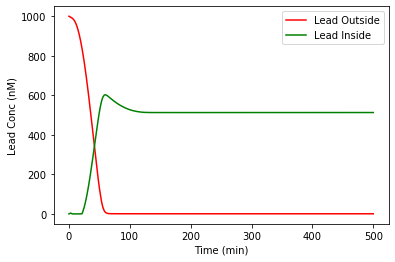

In [5]:
#TRIAL 2
#Change powers of the Hill function.

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pylab as plot
from decimal import Decimal
import math as math
from scipy.integrate import solve_ivp

#Initialize some constants
vTX1 = 18.2       #reporter transcription rate constant
vTX2 = 18.2       #repressor transcription rate constant
KTX1 = 8.5        #Michaelis-Menten constant for reporter transcription 
KTX2 = 8.5        #Michaelis-Menten constant for repressor transcription
lam_m1 = 0.08     #reporter mRNA degradation rate constant
lam_m2 = 0.08     #repressor mRNA degradation rate constant
kTL1 = 0.0082       #Reporter translation rate constant, 0.0076
kTL2 = 0.0082       #Repressor translation rate constant, 0.0076
KTL1 = 29.9       #Michaelis-Menten constant for translation of reporter
KTL2 = 29.9       #Michaelis-Menten constant for translation of repressor
vlamTLR = 13.5    #Translation resources degradation rate constant
KlamTLR = 53.2    #Michaelis-Menten constant for degradation of TL resources
kmat = 0.244      #reporter maturation rate constant
k2R = 50          #repressor dimerization rate constant
k_2R  = 0.001     #repressor dimer dissociation rate constant
kr = 960          #association rate constant for repression
k_r = 2.4         #dissociation rate constant for repression
kdr1 = 3.0e7      #association rate constant for first derepression mechanism 
k_dr1 = 12        #dissociation rate constant for first derepression mechanism
kdr2 = 3.0e7      #association rate constant for second derepression mechanism   
k_dr2 = 4800      #dissociation rate constant for second derepression mechanism
kleak = 0.0033    #leak reporter transcription rate constant
vTX3 = 8.2        #pbrD transcription rate constant
vTX4 = 8.2        #pbrT transcription rate constant
KTX3 = 8.5        #Michaelis-Menten constant for pbrD transcription
KTX4 = 8.5        #Michaelis-Menten constant for pbrT transcription
kTL3 = 0.082       #pbrD translation rate constant, 0.0076
kTL4 = 0.082       #pbrT translation rate constant, 0.0076
KTL3 = 29.9       #Michaelis-Menten constant for translation of pbrD
KTL4 = 29.9       #Michaelis-Menten constant for translation of pbrT
lam_m3 = 0.08     #pbrD mRNA degradation rate constant
lam_m4 = 0.08     #pbrT mRNA degradation rate constant
P = 7.4*1e-4      #Permeability, for now using P of Na+ ~ 7.4*1e-4 nm/s

#DONOT KNOW VALUES OF CONSTANTS GIVEN BELOW----------\\\\\\\\\\|||||||||||||//////////----------\\\\\\\\\|||||||/////////
vin = 1         #Rate of Lead influx
Kin = 1e2         #Lead influx Michealis-Menten coefficient 
kseq = 1e5       #Lead Sequestration 
k_seq = 1e-15      #Reverse of 'kseq'

def model(t,z):
    
    #Initialize variables in a vector
    mT = z[0]
    T = z[1]
    Aout = z[2]
    A = z[3]          #analyte                       #R2A2 - repressor-operator complex
    mR = z[4]         #repressor mRNA
    R = z[5]          #repressor monomer
    R2 = z[6]         #repressor dimer               #R2O - free operator of reporter gene
    O = z[7]          #inactive repressor
    mF = z[8]         #reporter mRNA
    Fin = z[9]        #inactive reporter
    F = z[10]         #reporter
    mD = z[11]
    D = z[12]
    DA2 = z[13]
    TLR = z[14]       #Translation resources
    
    #ODEs  
    
    dmTdt = (vTX4*(GR**q)/((KTX4**q)+(GR**q))) - lam_m4*mT
    dTdt = (kTL4*TLR*(mT**p))/((KTL3**p)+(mT**p)+(mD**p)+(mR**p)+(mF**p)) 
    
    T_mol = math.floor(T*0.6022)  #Volume of cell = 10^-15 L, Concentration [T] is in 10^-9 mol/L
    
    #LEAD TRANSPORT MODELLING ---------------------------->>>>>>>>>>>>>>><<<<<<<<<<<<<<<<--------------------------
    
    dAoutdt = -T_mol*(vin*Aout)/(Kin + Aout) - P*(Aout - A)                                                                   #Lead Influx through pbrT
    dAdt = T_mol*(vin*Aout)/(Kin + Aout) + P*(Aout-A) - n*kseq*(A**n)*D + n*k_seq*DA2 - 2*kdr1*(A**2)*R2 + 2*k_dr1*((TA-A-Aout-n*DA2)/2) - 2*kdr2*(A**2)*(TO-O) + 2*k_dr2*O*((TA-A-Aout-n*DA2)/2)  #Analyte Conc
    
    #LEAD TRANSPORT MODELLING ---------------------------->>>>>>>>>>>>>>><<<<<<<<<<<<<<<<--------------------------
    
    dmRdt = (vTX2*(GR**q)/((KTX2**q)+(GR**q))) - lam_m2*mR                                       #Repressor mRNA Conc
    dRdt = (kTL2*TLR*(mR**p)/((KTL3**p)+(mT**p)+(mD**p)+(mR**p)+(mF**p))) - 2*k2R*(R**2) + 2*k_2R*R2             #Repressor Conc  
    dR2dt = k2R*(R**2) - k_2R*R2 - kr*R2*O + k_r*(TO-O) - kdr1*(A**2)*R2 + k_dr1*((TA-A-Aout-n*DA2)/2)      #Repressor dimer Conc               
    
    dOdt = -kr*R2*O + k_r*(TO-O) + kdr2*(A**2)*(TO-O) - k_dr2*O*((TA-A-Aout-n*DA2)/2)                       #Operator Conc
    dmFdt = (vTX1*(O**q)/((KTX1**q)+(O**q))) - lam_m1*mF + kleak*(TO-O)                          #Reporter mRNA Conc
    dFindt = (kTL1*TLR*(mF**p)/((KTL3**p)+(mT**p)+(mD**p)+(mR**p)+(mF**p))) - kmat*Fin                           #Inactive Reporter Conc
    dFdt = kmat*Fin                                                                              #Active Reporter Conc  
    
    dmDdt = (vTX3*(O**q)/((KTX3**q)+(O**q))) - lam_m3*mD + kleak*(TO-O)
    dDdt = (kTL3*TLR*(mD**p))/((KTL3**p)+(mT**p)+(mD**p)+(mR**p)+(mF**p))  - kseq*DA2
    dDA2dt = kseq*(A**n)*D - k_seq*DA2
    
    dTLRdt = -vlamTLR*TLR/((KlamTLR)+(TLR))                                                      #Translation Resources Conc
    
    return [dmTdt, dTdt, dAoutdt, dAdt, dmRdt, dRdt, dR2dt, dOdt, dmFdt, dFindt, dFdt, dmDdt, dDdt, dDA2dt, dTLRdt]


#Initial Conditions, conc in nM
mR0 = 0
R0 = 0
R20 = 0
R21 = 300
R2O0 = 0
R2A20 = 0
mF0 = 0
Fin0 = 0
F0 = 0
mD0 = 0
D0 = 0
DA20 = 0
mT0 = 0
T0 = 2
TLR0 = 1520

O0 = 8
GR = O0

Aout0 = 1e3
A0 = 0                 #Lead Concentration

n = 1       #Sequestration Number
p = 5       #Translation Hill function power
q = 2       #Transcription Hill function power

TA = Aout0 + A0 + 2*R2A20 + n*DA20
TO = O0 + R2O0        #LOOK AT THIS----------------------<<<<<<

z = [mT0,T0,Aout0,A0,mR0,R0,R20,O0,mF0,Fin0,F0,mD0,D0,DA20,TLR0]

ans = solve_ivp(fun=model, t_span=(0,500), y0=z, method = 'BDF')

LDout = ans['y'][2]
LDin = ans['y'][3]

plt.plot(ans['t'],LDout, 'r', label = 'Lead Outside')
plt.plot(ans['t'],LDin, 'g', label = 'Lead Inside')
plt.xlabel("Time (min)")
plt.ylabel("Lead Conc (nM)")
plt.legend()
plt.show()

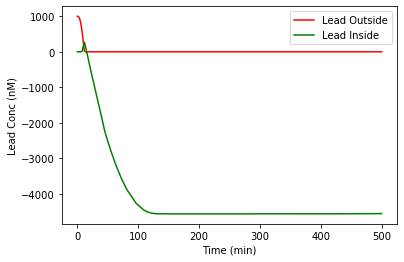

In [6]:
#TRIAL 2
#Change powers of the Hill function.

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pylab as plot
from decimal import Decimal
import math as math
from scipy.integrate import solve_ivp

#Initialize some constants
vTX1 = 18.2       #reporter transcription rate constant
vTX2 = 18.2       #repressor transcription rate constant
KTX1 = 8.5        #Michaelis-Menten constant for reporter transcription 
KTX2 = 8.5        #Michaelis-Menten constant for repressor transcription
lam_m1 = 0.08     #reporter mRNA degradation rate constant
lam_m2 = 0.08     #repressor mRNA degradation rate constant
kTL1 = 0.082     #Reporter translation rate constant, 0.0076
kTL2 = 0.082     #Repressor translation rate constant, 0.0076
KTL1 = 29.9       #Michaelis-Menten constant for translation of reporter
KTL2 = 29.9       #Michaelis-Menten constant for translation of repressor
vlamTLR = 13.5    #Translation resources degradation rate constant
KlamTLR = 53.2    #Michaelis-Menten constant for degradation of TL resources
kmat = 0.244      #reporter maturation rate constant
k2R = 50          #repressor dimerization rate constant
k_2R  = 0.001     #repressor dimer dissociation rate constant
kr = 960          #association rate constant for repression
k_r = 2.4         #dissociation rate constant for repression
kdr1 = 3.0e7      #association rate constant for first derepression mechanism 
k_dr1 = 12        #dissociation rate constant for first derepression mechanism
kdr2 = 3.0e7      #association rate constant for second derepression mechanism   
k_dr2 = 4800      #dissociation rate constant for second derepression mechanism
kleak = 0.0033    #leak reporter transcription rate constant
vTX3 = 8.2        #pbrD transcription rate constant
vTX4 = 8.2        #pbrT transcription rate constant
KTX3 = 8.5        #Michaelis-Menten constant for pbrD transcription
KTX4 = 8.5        #Michaelis-Menten constant for pbrT transcription
kTL3 = 0.082     #pbrD translation rate constant, 0.0076
kTL4 = 0.082     #pbrT translation rate constant, 0.0076
KTL3 = 29.9       #Michaelis-Menten constant for translation of pbrD
KTL4 = 29.9       #Michaelis-Menten constant for translation of pbrT
lam_m3 = 0.08     #pbrD mRNA degradation rate constant
lam_m4 = 0.08     #pbrT mRNA degradation rate constant
P = 7.4*1e-4      #Permeability, for now using P of Na+ ~ 7.4*1e-4 nm/s

#DONOT KNOW VALUES OF CONSTANTS GIVEN BELOW----------\\\\\\\\\\|||||||||||||//////////----------\\\\\\\\\|||||||/////////
vin = 1         #Rate of Lead influx
Kin = 1e2         #Lead influx Michealis-Menten coefficient 
kseq = 1e5       #Lead Sequestration 
k_seq = 1e-15      #Reverse of 'kseq'

def model(t,z):
    
    #Initialize variables in a vector
    mT = z[0]
    T = z[1]
    Aout = z[2]
    A = z[3]          #analyte                       #R2A2 - repressor-operator complex
    mR = z[4]         #repressor mRNA
    R = z[5]          #repressor monomer
    R2 = z[6]         #repressor dimer               #R2O - free operator of reporter gene
    O = z[7]          #inactive repressor
    mF = z[8]         #reporter mRNA
    Fin = z[9]        #inactive reporter
    F = z[10]         #reporter
    mD = z[11]
    D = z[12]
    DA2 = z[13]
    TLR = z[14]       #Translation resources
    
    #ODEs  
    
    dmTdt = (vTX4*(GR**q)/((KTX4**q)+(GR**q))) - lam_m4*mT
    dTdt = (kTL4*TLR*(mT**p))/((KTL3**p)+(mT**p)) 
    
    T_mol = math.floor(T*0.6022)  #Volume of cell = 10^-15 L, Concentration [T] is in 10^-9 mol/L
    
    #LEAD TRANSPORT MODELLING ---------------------------->>>>>>>>>>>>>>><<<<<<<<<<<<<<<<--------------------------
    
    dAoutdt = -T_mol*(vin*Aout)/(Kin + Aout) - P*(Aout - A)                                                                   #Lead Influx through pbrT
    dAdt = T_mol*(vin*Aout)/(Kin + Aout) + P*(Aout-A) - n*kseq*(A**n)*D + n*k_seq*DA2 - 2*kdr1*(A**2)*R2 + 2*k_dr1*((TA-A-Aout-n*DA2)/2) - 2*kdr2*(A**2)*(TO-O) + 2*k_dr2*O*((TA-A-Aout-n*DA2)/2)  #Analyte Conc
    
    #LEAD TRANSPORT MODELLING ---------------------------->>>>>>>>>>>>>>><<<<<<<<<<<<<<<<--------------------------
    
    dmRdt = (vTX2*(GR**q)/((KTX2**q)+(GR**q))) - lam_m2*mR                                       #Repressor mRNA Conc
    dRdt = (kTL2*TLR*(mR**p)/((KTL3**p)+(mR**p))) - 2*k2R*(R**2) + 2*k_2R*R2             #Repressor Conc  
    dR2dt = k2R*(R**2) - k_2R*R2 - kr*R2*O + k_r*(TO-O) - kdr1*(A**2)*R2 + k_dr1*((TA-A-Aout-n*DA2)/2)      #Repressor dimer Conc               
    
    dOdt = -kr*R2*O + k_r*(TO-O) + kdr2*(A**2)*(TO-O) - k_dr2*O*((TA-A-Aout-n*DA2)/2)                       #Operator Conc
    dmFdt = (vTX1*(O**q)/((KTX1**q)+(O**q))) - lam_m1*mF + kleak*(TO-O)                          #Reporter mRNA Conc
    dFindt = (kTL1*TLR*(mF**p)/((KTL3**p)+(mF**p))) - kmat*Fin                           #Inactive Reporter Conc
    dFdt = kmat*Fin                                                                              #Active Reporter Conc  
    
    dmDdt = (vTX3*(O**q)/((KTX3**q)+(O**q))) - lam_m3*mD + kleak*(TO-O)
    dDdt = (kTL3*TLR*(mD**p))/((KTL3**p)+(mD**p))  - kseq*DA2
    dDA2dt = kseq*(A**n)*D - k_seq*DA2
    
    dTLRdt = -vlamTLR*TLR/((KlamTLR)+(TLR))                                                      #Translation Resources Conc
    
    return [dmTdt, dTdt, dAoutdt, dAdt, dmRdt, dRdt, dR2dt, dOdt, dmFdt, dFindt, dFdt, dmDdt, dDdt, dDA2dt, dTLRdt]


#Initial Conditions, conc in nM
mR0 = 0
R0 = 0
R20 = 0
R21 = 300
R2O0 = 0
R2A20 = 0
mF0 = 0
Fin0 = 0
F0 = 0
mD0 = 0
D0 = 0
DA20 = 0
mT0 = 0
T0 = 2
TLR0 = 1520

O0 = 8
GR = O0

Aout0 = 1e3
A0 = 0                 #Lead Concentration

n = 1       #Sequestration Number
p = 1       #Translation Hill function power
q = 1       #Transcription Hill function power

TA = Aout0 + A0 + 2*R2A20 + n*DA20
TO = O0 + R2O0        #LOOK AT THIS----------------------<<<<<<

z = [mT0,T0,Aout0,A0,mR0,R0,R20,O0,mF0,Fin0,F0,mD0,D0,DA20,TLR0]

ans = solve_ivp(fun=model, t_span=(0,500), y0=z, method = 'BDF')

LDout = ans['y'][2]
LDin = ans['y'][3]

plt.plot(ans['t'],LDout, 'r', label = 'Lead Outside')
plt.plot(ans['t'],LDin, 'g', label = 'Lead Inside')
plt.xlabel("Time (min)")
plt.ylabel("Lead Conc (nM)")
plt.legend()
plt.show()